In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from tqdm import tqdm

plt.style.use('dark_background')

---

Text(0.5, 1.0, 'N=217')

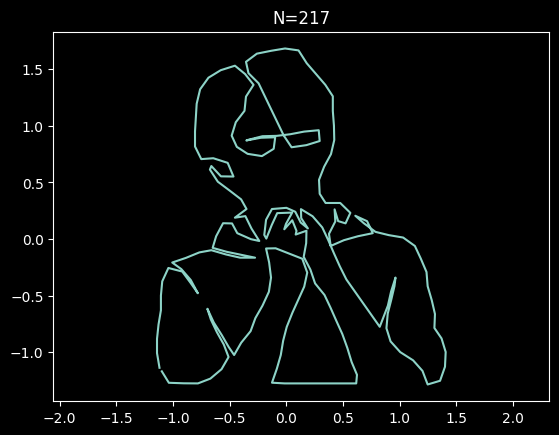

In [4]:
# in case you have > 300 points
# subsample the points using [::20] (change 20)
# until you have < 300 points

curve = np.load("input/path.npy")[::20]
curve -= curve.mean()
curve /= curve.std()

plt.plot(curve.real, curve.imag)
plt.axis('equal')
plt.title(f"N={len(curve)}")

In [6]:
curve_h = np.fft.fft(curve) / len(curve)
curve_h = pd.DataFrame({
    "real": curve_h.real,
    "imag": curve_h.imag
})
curve_h["amplitude"] = np.sqrt(curve_h["real"]**2 + curve_h["imag"]**2)
curve_h["phase"] = np.arctan2(curve_h["imag"], curve_h["real"])
curve_h["freq"] = np.fft.fftfreq(len(curve), d=1/len(curve))

curve_h = curve_h.sort_values("amplitude", ascending=False).reset_index(drop=True)

curve_h.head()

,real,imag,amplitude,phase,freq
0,-0.726440,-0.360474,0.810960,-2.680974,-1.0
1,0.106292,-0.220040,0.244368,-1.120794,-2.0
2,-0.026910,-0.231485,0.233044,-1.686528,2.0
3,-0.186763,-0.113722,0.218662,-2.594647,4.0
4,-0.202456,0.005678,0.202536,3.113557,-3.0


---

In [7]:
if not os.path.exists('tmp'):
    os.makedirs('tmp')

for file in os.listdir('tmp'):
    os.remove(f'tmp/{file}')

In [8]:
def neon_plot(x, y, ax=None):
    if ax is None:
        ax = plt.gca()
    line, = ax.plot(x, y, lw=1, zorder=6, color='yellow')
    for cont in range(6, 2, -1):
        ax.plot(x, y, lw=cont, color=line.get_color(), zorder=5,
                alpha=0.05)
    return ax

In [9]:
time = np.linspace(0, 2*np.pi, len(curve_h))
hist = []

for i, t in enumerate(tqdm(time)):
    plt.figure(figsize=(10, 10))
    plt.xlim(curve.real.min()*1.2, curve.real.max()*1.2)
    plt.ylim(curve.imag.min()*1.2, curve.imag.max()*1.2)
    plt.axis('off')
    plt.gca().set_aspect('equal', adjustable='box')

    x_prev, y_prev = 0, 0
    for row in curve_h.itertuples():
        circle = plt.Circle((x_prev, y_prev), row.amplitude, color='lightblue', fill=False)
        plt.gca().add_artist(circle)

        dx = row.amplitude * np.cos(row.freq * t + row.phase)
        dy = row.amplitude * np.sin(row.freq * t + row.phase)

        plt.arrow(x_prev, y_prev, dx, dy, color='white')

        x_prev, y_prev = x_prev + dx, y_prev + dy

    hist = np.concatenate([[x_prev + y_prev * 1j], hist])
    neon_plot(hist.real, hist.imag)

    plt.tight_layout()
    plt.savefig(f'tmp/{i:04}.png')
    plt.close()

 70%|███████   | 152/217 [00:57<00:23,  2.73it/s]

In [ ]:
os.system('ffmpeg -r 30 -i tmp/%04d.png -vcodec libx264 -y -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" out.mp4')